# SigNow Walk Through

### Gentle Introduction to SigNow, the Signature Method and the Nowcasting Problem
SigNow allows econometricians, and other like-minded users, to generate a nowcast with the Signature Method, using their own target and indicator data.

SigNow is a tool to be utilitised under different economic settings, it validates input, allows you to specify signature and regression parameters and quickly choose between the types of nowcast (Static or Recursive) you want to run. 

The Signature method refers to a collection of feature extraction techniques that can be applied to multivariate time series. The path Signature is a mathmatical object that captures geometric properties of sequential data. To learn more about the generalised signature method we recommend reading [Morrill et al., 2021](https://arxiv.org/pdf/2006.00873.pdf) and to learn more about Nowcasting with signature methods we recommend reading our paper Nowcasting with signature methods (Cohen et al., 2023).

Finally, nowcasting refers to the real-time or quasi real-time estimation of the evolution of a given target variable, where we are estimating the latest or the current movements of the target (reference period) based on an incomplete information set of indicators. Nowcasting is necessary as key economic variables are often published with a significant lag, and there is a need to have fast, reliable estimates of delayed economic indicators. 

### Walk Through Contents

This walk through will introduce the core functionality of SigNow on some generated indicator and target data. This data simulates more traditional nowcasting scenarios (indicators that are of a monthly frequency and targets that are of a quarterly frequency) and follows all the criteria you would expect data to have in the nowcasting literature (e.g. time series is stationary etc.). You can find the data generator in this repo [here]() and the helper functions for this demo [here]().

Set Up and Introduction:
* Setting Parameters and Setting your Training, Test and Reference Periods
* Running Static and Recursive Nowcasts 
* Inspecting model performance statistics


___________________________________________________________________

# Set up and Introduction 

____________________________________________________________________

In [1]:
import pandas as pd

from signow.signature_nowcasting import SigNowcaster
from signow.data_generator import create_data

from walkthrough_helper_funcs import display_indicators, display_target, display_period_data, print_period_dates, display_t_predictions, display_barh_coef

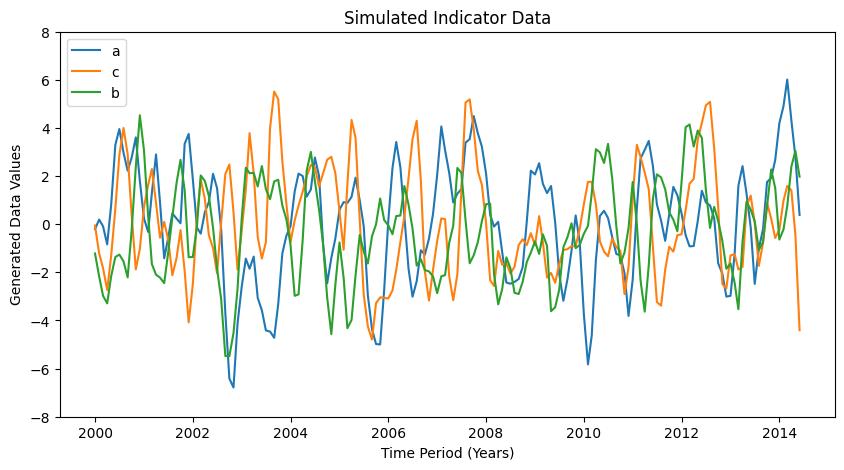

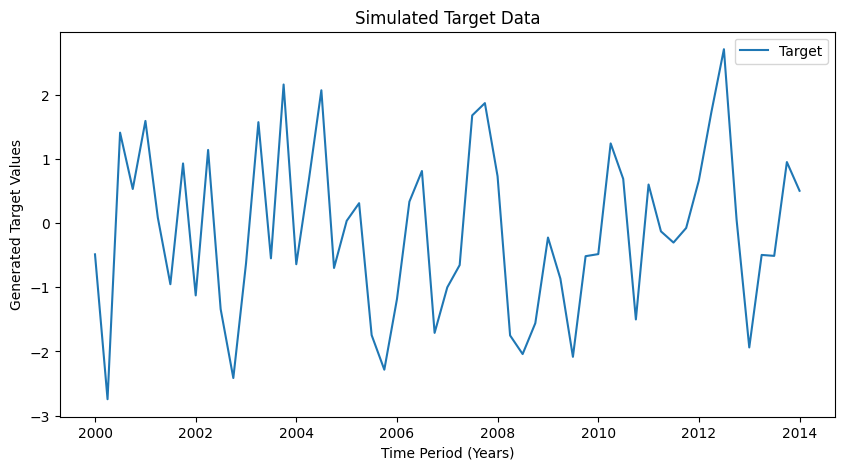

In [2]:
# Generate the target and indicator data
indicators, target = create_data(start_date='2000-01-01',
                                end_date='2014-06-01',
                                num_indicators=3,
                                wide_indic_df=False)
ref_realisation = target[target.index == '2014-04-01']
target=target[target.index < '2014-03-01']
# Plot indicator and target data
display_indicators(indicators)
display_target(target)

_____________________________________________________________________

### Setting Parameters

_____________________________________________________________________

SigNow has many parameters that *can* be specified. These parameters fall into either: parameters for the regression, parameters for the Signature and parameters for running principal components analysis (PCA - optional). If parameters are not specified then default values will be set for parameters.  

Below is a brief summary of the parameters by category. 

The parameters for the regression are dictated by your chosen __regressor__. Please see [sklearn.linear_model](https://scikit-learn.org/stable/modules/linear_model.html) documentation for types of regressors and full parameters. As a minimum, the parameters one should enter when running Elastic-Net as your regressor are:
- "alpha" [float]
- "l1_ratio" [float]
- "fit_intercept" [bool]

The parameters for the Signature terms are as follows:
- "window_type" [str] - The type of window used for generating the signatures - possible values are 'days', 'ind' and None. Arguments 'days' and 'ind' behave as moving windows. None acts as an expanding window.
- "max_length" [int] - When "window_type" is set to 'days' or 'ind', 'max_length' is the number of days or rows to index by
- "fill_method" [str] - how missing data should be filled - typical values 'ffill', 'bfill' or 'rectilinear'- other fill methods found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)
- "level" [int] - truncation level for the variables
- "t_level" [int] - truncation level for the time parameter
- "basepoint" [bool] - Add basepoint to signature to remove lateral invariance
- "use_multiplier" [bool] - Multiply signatures corresponding to time only by specified multiplier
- "keep_sigs" [str] - filters generated signature terms - values 'all', 'innermost', 'all_linear' and None

The parameters for PCA (optional) are as follows:
- "pca_fill_method" [str]
- "k" [int]

_________________________________________________________________________________________________


In [3]:
#setting the parameters for the Signature
sig_params={
    "window_type": "days",
    "max_length": 365,
    "fill_method": "ffill",
    "level": 2,
    "t_level": 2,
    "basepoint": False,
    "use_multiplier": False,
    "keep_sigs": "all"}
#setting parameters for the regression
regress_params = {
    "alpha": 0.1,
    "l1_ratio": 0.5,
    "fit_intercept": True}
pca_params = {
    "pca_fill_method":"backfill",
    "k":2}

params = {"regress_params": {**regress_params},
         "sig_params": {**sig_params}, 
         "pca_params": {**pca_params}}

_________________________________________________________________________

### Initialising SigNow: Setting your Regressor and Training, Test and Reference Periods 

When initialising SigNow you want to specify the type of regressor you want to apply to the Signature terms. As mentioned in the section above, Setting Parameters, the __regressor__ is run using [sklearn.linear_model](https://scikit-learn.org/stable/modules/linear_model.html). Supported SigNow regressors match those which are feasible for regressing on Signature terms. These are: 
- [Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)
- [Linear-Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

Along with your regressor, you can also enter start and end dates for your training, test and reference periods. These dates should be in an interpretable format to be converted to datetime format (e.g. "YYYY-MM-DD"). __Please note__ that you don't have to enter all dates when initialising SigNow, it is flexible and you can just enter the end of the training period or start of your test period as a minimum. The arguments to enter in for the dates are as follows:

- "start_train" - The start date for your training period (e.g. "2000-01-01")
- "end_train" - The end date for your training period (e.g. "2007-12-31")
- "start_test" - The start date for your test period (e.g. "2008-02-01")
- "end_test" - The end date for your test period (e.g. "2014-01-31")
- "start_ref" - The start date for your reference period (e.g. "2014-03-01" - reference period example would be for quarterly target data)
- "end_ref" - The end date for your reference period (e.g. "2014-06-31" - reference period example would be for quarterly target data)

You can inspect the data series for your training, test and reference periods by calling the initiated object and the data period. Please see examples below for further details. 

An optional argument that you can specify when initialising SigNow is by applying the principle component analysis (PCA) parameter. By default, the "apply_pca" parameter is set to False.


Start of the training period:  2000-01-01 00:00:00
End of the training period:  2004-12-31 23:59:59.999999999
Start of the test period:  2005-01-01 00:00:00
End of the test period:  2014-06-30 23:59:59.999999999
Start of the reference period:  2014-04-01 00:00:00
End of the reference period:  2014-06-30 23:59:59.999999999


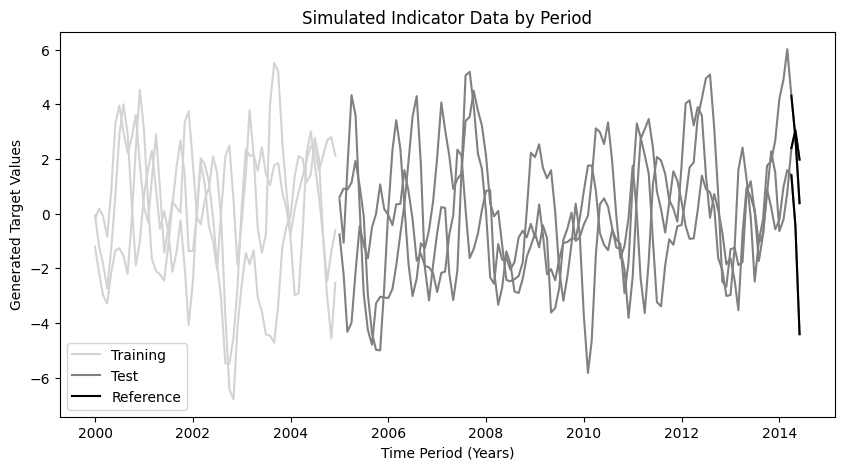

In [4]:
# Initialise SigNow, specifiy the time periods, set the regressor and set apply PCA to False
sn_ = SigNowcaster(X=indicators, y=target,
                    start_test='2005-01-01',
                    regressor="elasticnet",
                    apply_pca=False, **params)
# Show the Training, Test and Reference dates
print_period_dates(sn_)
display_period_data(sn_)

__________________________________________________________________________________

### Running Static and Recursive Nowcasts 

SigNow allows you to easily run either Static or Recursive Nowcasts. 

These types are common to the nowcasting field and can be described in the following ways:
- A Static Nowcast is a type of nowcast where your coefficients for the model are estimated over the training period (estimation sample) and then are constant when this model is applied over the test period.
- A Recursive Nowcast is a type of nowcast where your coefficients for the model are re-estimated over the training period (over an expanding estimation window). Hence the estimated values of the coefficients could change during the test period (nowcast evaluation sample).

Both types of nowcasts can be produced by simply calling your method followed by either  `.static_nowcast()` or `.recursive_nowcast()`. Both of these will produce a nowcast for your reference period. Please note that when running each of these calls you can enter in or change any of your chosen parameters on initiation. 



In [5]:
sn_ = SigNowcaster(X=indicators, y=target,
                    start_test='2008-01-01',
                    regressor="elasticnet",
                    apply_pca=False, **params).fit()
# Run a Static nowcast and produce  
sn_static = sn_.static_nowcast()
sn_static

,y
2014-04-01,1.341142


SigNow can also run recursive nowcasts using the same `sn_` object that has been created in this example. Also we can change parameters we want in our call to either `.static_nowcast()` or `.recursive_nowcast()`. 

Below, using the same `sn_` object, SigNow will run a recursive nowcast for the same reference period as above, and change the start_test argument.

In [11]:
sn_recursive_pca = sn_.recursive_nowcast(start_test='2010-01-01')
sn_recursive_pca

,y
2014-04-01,0.95494


__________________________________________________________________

### Inspecting model performance statistics

With SigNow you can also access model performance statistics such as the Root-Mean-Square Error (RMSE), the residuals and also view how well the model performed against the realisation (the actual target observations). 

To see your the RMSE over the training and test periods, you can call your SigNowcaster object followed by either `.train_rmse_` or `.test_rmse_`.

The residuals can be accessed in a similar way by calling either `.train_residuals_` or `.test_residuals_`.

Finally, to understand how well the model performed against the target realisations we call the SigNowcaster object followed `.predict()` and enter in the data for the period using the `.data.` instance we viewed above.

In [12]:
sn_ = SigNowcaster(X=indicators, y=target,
                    start_test='2008-01-01',
                    regressor="elasticnet",
                    apply_pca=False, **params).fit()
sn_static = sn_.static_nowcast()

In [7]:
sn_.train_rmse_

0.7816919239078743

In [8]:
sn_.test_rmse_

0.872807179968027

`.train_residuals_` and `.test_residuals_` return this data as pd.DataFrame objects which can easily be plotted.

<AxesSubplot:title={'center':'Residuals for the Test Period'}, xlabel='Period', ylabel='Residuals'>

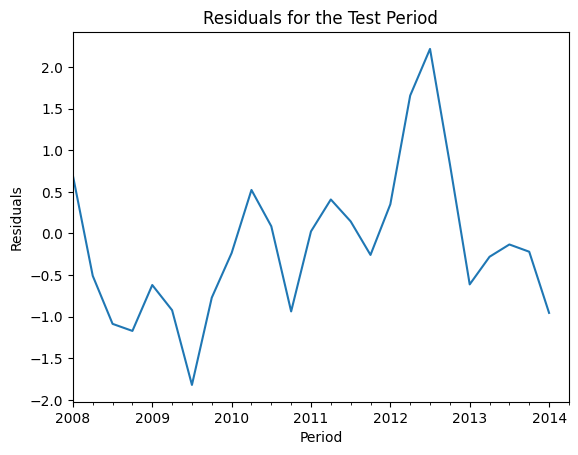

In [9]:
sn_.test_residuals_.plot(ylabel='Residuals', xlabel='Period', title='Residuals for the Test Period', legend=False)

The `.predict()` method is a useful way to return the predictions from the model.

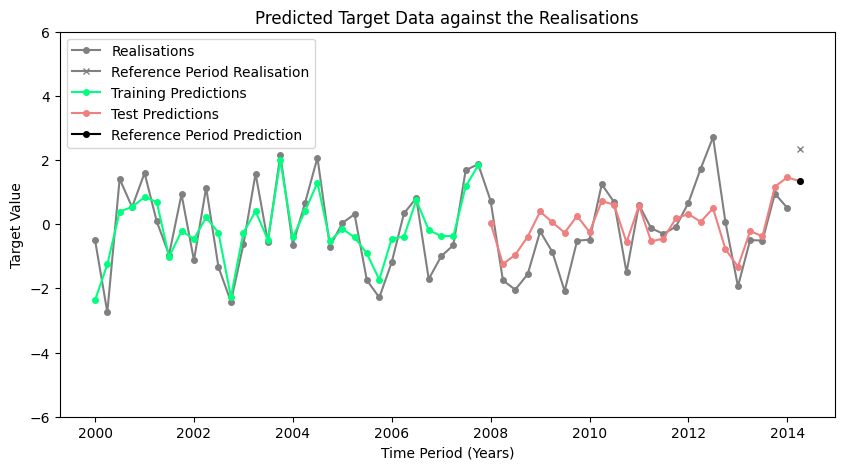

In [13]:
# Predictions
y_train = sn_.predict(sn_.data.X_train())
y_test = sn_.predict(sn_.data.X_test())
y_ref = sn_static

display_t_predictions(y_train, y_test, y_ref, target, ref_realisation)


With SigNow you can also inspect your coefficients and inspect these against the signature terms by calling the `.model_` element of you Signature object.  

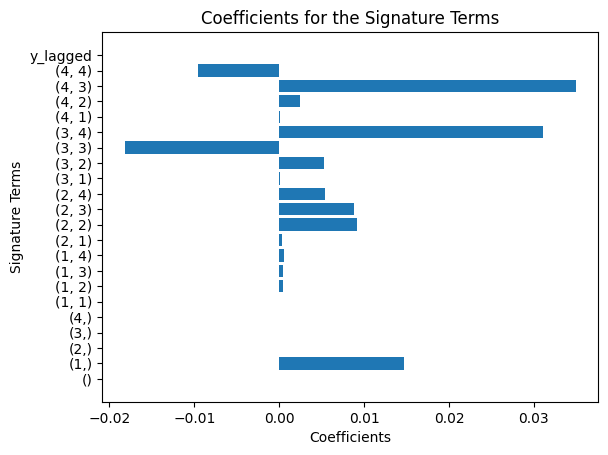

In [14]:
# Model coefficents 
coef = sn_.model_.estimator_['regression'].coef_
# Inspect the signature terms for the training period
sig_terms_train = sn_.model_.transform_pipe_.fit_transform(X=sn_.data.X_train(), y=sn_.data.y_train())

display_barh_coef(coef, sig_terms_train)

_______________________________________________________________________________________________